In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, PReLU, ReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# GAN: Generative adversarial network

3 elements:
- Generator
- Adversarial
- Network

Brief intro:
- Generator: takes a noise (latent) vector, it outputs a FAKE image
- Adversarial: takes the image and predict the prob of being REAL (the discriminator)
- Network: it can be with Dense or Convulation layers!

## Training:
- Basically, I train the Generator (frozening the Adversarial ) and then frozening the Generator, I train the adversarial for detecting if is real or not!

In [4]:
'''
Given an input image, the Discriminator outputs the likelihood of the image being real.
'''
def build_discriminator():
    model = Sequential()
    # flattening the image!
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid')) # returning a prob
    model.summary()

    img = Input(shape=img_shape)
    prob = model(img)
    return Model(img, prob)

In [5]:
'''
Given input of noise (latent) vector, the Generator produces an image.
'''
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image
    return Model(noise, img)

# Loading the data!

In [6]:
batch_size  = 128
 # Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
X_train = np.expand_dims(X_train, axis=3) 

half_batch = int(batch_size / 2)

In [7]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

# Let's define the models:
- Discriminator
- Generator

### REMARK: I need to not train the discriminator while the generator is training!

In [8]:
'''
GAN architecture:
- Defining the Discriminator and compile it! (this will be used for the indipendent training)
- Defining the Combined model: 
    - This takes the random input z and pass it through the Generator model and then through the discriminator!
    - Remark: setting the discriminator's trainable flag inside the combined model to FALSE 
'''
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

## First step:
### Build the discriminator!
discriminator = build_discriminator()
## Create the model to train independently!
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

## Second step:
### Build the combined model!

### 1. Build the generator!
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    #In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)
### 2. Insert the Discriminator  in the combined model (modifying it)
discriminator.trainable = False  
prob = discriminator(img)  #Validity check on the generated image

### Let's compile the combined model!
combined = Model(z, prob)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [9]:
EPOCHS = 100000

In [ ]:
'''
Here the training is in the following order:
    1. Training of the discriminator
        A. Training separatly on real and fake images (Research showed that separate training is more effective)
    2. Training of the combined model
        A. Creating a batch of FAKE images with the  label 1.
           This is done since the goal is to produce images that are considered valid (1) by the autoencoder!
           So, we measure how good the generator is!
'''
for epoch in range(EPOCHS):
    ## taking half of a batch for trainig with real images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    ## get the latent vector to produce fake images
    noise = np.random.normal(0, 1, (half_batch, 100))

    # Generate a half batch of fake images
    gen_imgs = generator.predict(noise)

    # Train the discriminator on real and fake images, separately
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    #take average loss from real and fake images. 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    noise = np.random.normal(0, 1, (batch_size, 100)) 

    valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

    g_loss = combined.train_on_batch(noise, valid_y)

    print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

'''
REMARK: 
In each epoch:
- The discriminator is trained independently using halh batch with FAKE images and half batch with REAL images
- The combined model is trained on a  batch of FAKE images with all 1 labels
    - Here the goal is to update the weights of the generator in order to produce images that minimize the loss here
    - In other words, the loss is minimized if the discriminator commits more mistakes!  
    - More mistakes means the generator is able to produce better fake images!
    - Given the labels are set to 1, the maximum loss is got if the discriminator says they are all 0 (it classifies correctly)!
'''


In [ ]:
# saving the model
generator.save('generator_model2.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


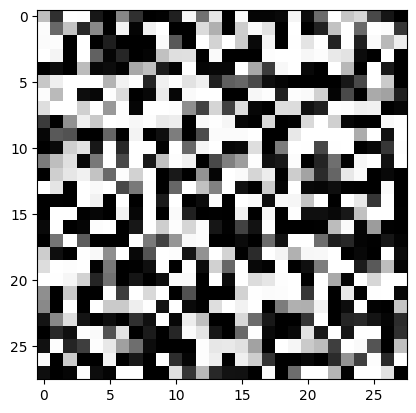

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

model = load_model('generator_model2.keras')


vector = randn(100) #Vector of random numbers 
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()